# Кейс №6

## Прогнозирование исходов заболевания циррозом печени с помощью ML

## Участники:

- Алёна Лозинская
- Валентина Кулакова
- Дмитрий Волобуев
- Артур Григорян
- Ильсия Коткова
- Матвей Радаев

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
plt.style.use("default")
sns.set_palette("Set2")

RANDOM_STATE = 42
TARGET_COL = "Status"
DROP_COL = ["id", "N_Days"]

# Этап I. Предобработка данных для ML

Загрузим данные, разделим наши признаки на числовые и категориальные, преобразуем таргет в бинарный, разделим на train и test.

In [4]:
df = pd.read_csv("../../data/train.csv").drop(columns=DROP_COL)

In [5]:
target_maps = {"C": 0, "D": 1}

binary_maps = {
    "Drug": {"Placebo": 0, "D-penicillamine": 1},
    "Sex": {"F": 0, "M": 1},
    "Ascites": {"N": 0, "Y": 1},
    "Hepatomegaly": {"N": 0, "Y": 1},
    "Spiders": {"N": 0, "Y": 1}
}

binary_features = list(binary_maps.keys())
multi_category_features = ["Edema", "Stage"]

numeric_features = ["Age", "Bilirubin", "Cholesterol", "Albumin", "Copper",
                    "Alk_Phos", "SGOT", "Tryglicerides", "Platelets", "Prothrombin"]

Исходный таргет с тремя категориями преобразуем в две и будем решать задачу бинарной классификации.

Класс CL означает, что пациент выжил благодаря трансплантации печени. А информации о том, кому была сделана или назначена трансплантация, в данных нет. Поэтому мы не можем корректно предсказать событие CL по исходным биохимическим показателям - оно зависит не только от тяжести болезни, но и от внешних факторов (решение врача, наличие органа, успешность операции). Среди представителей класса D также могли быть пациенты, которые перенесли трансплантацию печени, равно как и в классе C могут быть пациенты, которым предстоит операция, но мы об этом не знаем. Кроме того, CL очень малочисленный: всего 3.5% против 33.7% и 62.8% классов D и C соответственно. Поэтому его разумно исключить и решать задачу в виде бинарной классификации:

- Класс 0, умеренная стадия заболевания — C (пациент жив)
- Класс 1, тяжёлая стадия заболевания — D (летальный исход)

In [6]:
df = df[df[TARGET_COL] != 'CL'].reset_index(drop=True)

df[TARGET_COL] = df[TARGET_COL].map(target_maps)

df[TARGET_COL].value_counts(normalize=True)

Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64

Разделим все данные на train и test. Подбор методов обработки признаков, настройку гиперпараметров и оценку качества будем проводить только на кросс-валидации на train. Test служит для финальной оценки качества лучшей модели.

In [7]:
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

In [8]:
print("Распределение таргета на train:")
print(y_train.value_counts(normalize=True))

print("=="*25)

print("Распределение таргета на test:")
print(y_test.value_counts(normalize=True))

Распределение таргета на train:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64
Распределение таргета на test:
Status
0    0.650721
1    0.349279
Name: proportion, dtype: float64


Числовые признаки оставим в исходном виде, поскольку ML-модели на основе деревьев не накладывают жёстких требований в виде масштабирования, коррекции асимметрии и борьбы с выбросами. Поэтому в качестве обработки признаков закодируем только категориальные фичи:

- бинарные как 0 и 1
- Edema и Stage через OrdinalEncoder

In [9]:
class BinaryMapper(BaseEstimator, TransformerMixin):
    """
    Превращает бинарные категориальные в 0/1 по заданному словарю.
    """
    def __init__(self, mapping: dict):
        self.mapping = mapping
        self.columns_ = list(mapping.keys())

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_df = X.copy() if isinstance(X, pd.DataFrame) else pd.DataFrame(X, columns=self.columns_)
        for col, mapping in self.mapping.items():
            X_df[col] = X_df[col].map(mapping)
        return X_df

    def get_feature_names_out(self, input_features=None):
        return self.columns_

In [10]:
processor = ColumnTransformer(
    transformers=[
        ("binary", BinaryMapper(binary_maps), binary_features),
        ("category", OrdinalEncoder(), multi_category_features)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

Будем использовать StratifiedKFold, чтобы в каждом фолде была соблюдена пропорция классов. Установим 5 фолдов.

In [11]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Этап II. Decision Tree

Напишем вспомогательные функции для визуализаций

In [12]:
# нарисовать дерево
def plot_tree_from_estimator(estimator, tree_step_name="dectree"):

    if hasattr(estimator, "best_estimator_"):
        pipe = estimator.best_estimator_
    else:
        pipe = estimator

    tree_clf = pipe.named_steps[tree_step_name]
    preprocess = pipe.named_steps["preprocess"]
    feature_names = preprocess.get_feature_names_out()

    plt.figure(figsize=(24, 12), dpi=300)
    plot_tree(
        tree_clf,
        feature_names=feature_names,
        class_names=["0", "1"],
        filled=True,
        rounded=True
    )
    plt.show()


# барплот важности признаков
def plot_feature_importances(estimator, model_step_name="dectree", top_n=None, title="Важность признаков"):

    if hasattr(estimator, "best_estimator_"):
        pipe = estimator.best_estimator_
    else:
        pipe = estimator

    model = pipe.named_steps[model_step_name]
    preprocess = pipe.named_steps["preprocess"]

    feature_names = preprocess.get_feature_names_out()
    importances = model.feature_importances_

    df_imp = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values("importance", ascending=False)

    if top_n is not None:
        df_imp = df_imp.head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_imp, y="feature", x="importance")
    plt.xlabel("Важность признака")
    plt.ylabel("Признак")
    plt.title(title)
    plt.grid(axis="x", alpha=0.3)
    plt.tight_layout()
    plt.show()

    return df_imp


# кривые precision, recall, F1 в зависимости от порога
def plot_threshold_curves(estimator, X, y, cv, title="Зависимость метрик от порога"):

    if hasattr(estimator, "best_estimator_"):
        model = estimator.best_estimator_
    else:
        model = estimator

    y_proba = cross_val_predict(model, X, y, cv=cv, method="predict_proba", n_jobs=-1)[:, 1]

    thresholds = np.arange(0.1, 0.91, 0.05)
    recalls, precisions, f1s = [], [], []

    for thr in thresholds:
        y_thr = (y_proba >= thr).astype(int)
        recalls.append(recall_score(y, y_thr))
        precisions.append(precision_score(y, y_thr))
        f1s.append(f1_score(y, y_thr))

    plt.figure(figsize=(8, 4))
    plt.plot(thresholds, recalls, label="Recall")
    plt.plot(thresholds, precisions, label="Precision")
    plt.plot(thresholds, f1s, label="F1")
    plt.xlabel("Порог вероятности")
    plt.ylabel("Метрика")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# матрица ошибок
def plot_confusion_matrix_simple(y_true, y_pred, title="Матрица ошибок"):
    
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

## 1. DT

In [13]:
decision_tree = Pipeline([
    ("preprocess", processor),
    ("dectree", DecisionTreeClassifier(
        random_state=RANDOM_STATE))
])

param_grid = {
    'dectree__max_depth': [3, 5, 7, 10, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [1, 5, 10, 15, 20],
    'dectree__max_features': [None, 'sqrt', 'log2'],
    'dectree__criterion': ['gini', 'entropy'],
    'dectree__class_weight': [None, 'balanced']
}

gs_dt = GridSearchCV(
    decision_tree,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_dt.fit(X_train, y_train)
print("Дерево решений:")
print("Лучшие параметры:", gs_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_dt.best_score_)

Дерево решений:
Лучшие параметры: {'dectree__class_weight': 'balanced', 'dectree__criterion': 'entropy', 'dectree__max_depth': 3, 'dectree__max_features': 'sqrt', 'dectree__min_samples_leaf': 1, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.8461512242856044


In [14]:
y_pred_dt = cross_val_predict(
    gs_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель decision tree):")
print(classification_report(y_train, y_pred_dt))

Отчёт по классам (модель decision tree):
              precision    recall  f1-score   support

           0       0.89      0.67      0.76      3972
           1       0.58      0.85      0.69      2132

    accuracy                           0.73      6104
   macro avg       0.73      0.76      0.73      6104
weighted avg       0.78      0.73      0.74      6104



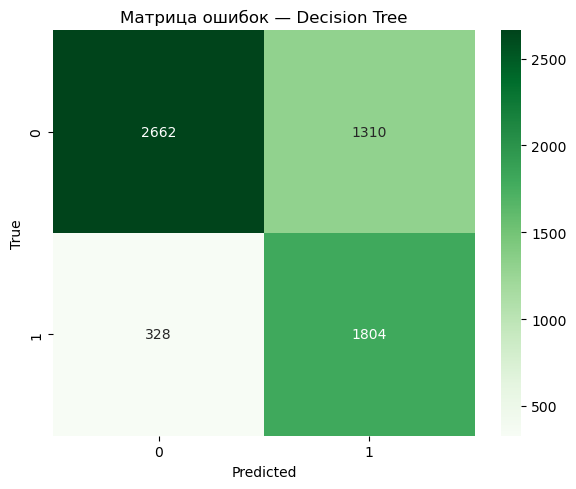

In [ ]:
plot_confusion_matrix_simple(y_train, y_pred_dt, title="Матрица ошибок — Decision Tree")

## 2. Decision Tree + Downsampling класса большинства

Используем простой способ, чтобы выровнять пропорцию классов: просто удалим некоторые объекты класса большинства.

In [ ]:
pipeline_us = ImbPipeline(steps=[
    ("preprocess", processor),
    ("undersample", RandomUnderSampler(random_state=RANDOM_STATE)),
    ("dectree", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    'dectree__max_depth': [3, 5, 7, 10, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [1, 5, 10, 15, 20],
    'dectree__max_features': [None, 'sqrt', 'log2'],
    'dectree__criterion': ['gini', 'entropy']
}

gs_us_dt = GridSearchCV(
    pipeline_us,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_us_dt.fit(X_train, y_train)
print("RandomDownSampler + дерево решений")
print("Лучшие параметры:", gs_us_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_us_dt.best_score_)

RandomDownSampler + дерево решений
Лучшие параметры: {'dectree__criterion': 'gini', 'dectree__max_depth': 3, 'dectree__max_features': 'sqrt', 'dectree__min_samples_leaf': 1, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.807678860045519


In [ ]:
y_pred_us_dt = cross_val_predict(
    gs_us_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomUnderSampler):")
print(classification_report(y_train, y_pred_us_dt))

Отчёт по классам (модель с RandomUnderSampler):
              precision    recall  f1-score   support

           0       0.88      0.73      0.80      3972
           1       0.61      0.81      0.70      2132

    accuracy                           0.76      6104
   macro avg       0.75      0.77      0.75      6104
weighted avg       0.78      0.76      0.76      6104



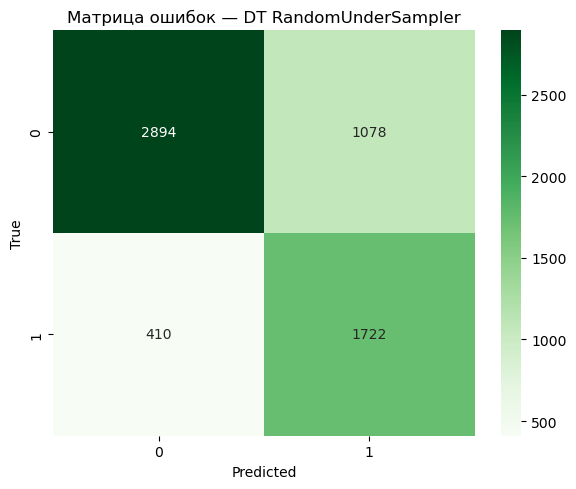

In [ ]:
plot_confusion_matrix_simple(y_train, y_pred_us_dt, title="Матрица ошибок — DT RandomUnderSampler")

В данном случае мы теряем в recall (0.85 -> 0.81), но выигрываем в precision (0.58 -> 0.61)

## 3. Decision Tree + Upsampling класса меньшинства

In [ ]:
pipeline_os = ImbPipeline(steps=[
    ("preprocess", processor),
    ("oversample", RandomOverSampler(random_state=RANDOM_STATE)),
    ("dectree", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    'dectree__max_depth': [3, 5, 7, 10, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [1, 5, 10, 15, 20],
    'dectree__max_features': [None, 'sqrt', 'log2'],
    'dectree__criterion': ['gini', 'entropy']
}

gs_os_dt = GridSearchCV(
    pipeline_os,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_os_dt.fit(X_train, y_train)
print("RandomOverSampler + дерево решений")
print("Лучшие параметры:", gs_os_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_os_dt.best_score_)

RandomOverSampler + дерево решений
Лучшие параметры: {'dectree__criterion': 'gini', 'dectree__max_depth': 3, 'dectree__max_features': 'sqrt', 'dectree__min_samples_leaf': 1, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7917702938945146


In [ ]:
y_pred_os_dt = cross_val_predict(
    gs_os_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель с RandomOverSampler):")
print(classification_report(y_train, y_pred_os_dt))

Отчёт по классам (модель с RandomOverSampler):
              precision    recall  f1-score   support

           0       0.87      0.76      0.81      3972
           1       0.64      0.79      0.71      2132

    accuracy                           0.77      6104
   macro avg       0.75      0.77      0.76      6104
weighted avg       0.79      0.77      0.77      6104



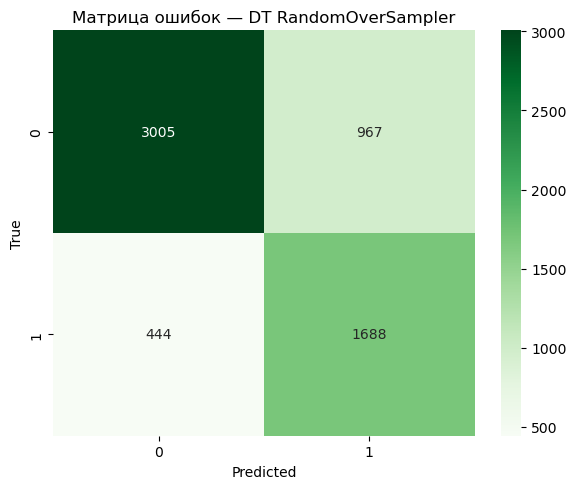

In [ ]:
plot_confusion_matrix_simple(y_train, y_pred_os_dt, title="Матрица ошибок — DT RandomOverSampler")

Ещё больше теряем в recall 0.81 -> 0.79, пропорционально выигрываем в precision 0.61 -> 0.64

## 4. Decision Tree + SMOTE

In [ ]:
pipeline_smote = ImbPipeline(steps=[
    ("preprocess", processor),
    ("smote", SMOTE(random_state=RANDOM_STATE, k_neighbors=5),
    ),
    ("dectree", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    'dectree__max_depth': [3, 5, 7, 10, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [1, 5, 10, 15, 20],
    'dectree__max_features': [None, 'sqrt', 'log2'],
    'dectree__criterion': ['gini', 'entropy']
}

gs_smote_dt = GridSearchCV(
    pipeline_smote,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_smote_dt.fit(X_train, y_train)
print("SMOTE + дерево решений")
print("Лучшие параметры:", gs_smote_dt.best_params_)
print("Лучший recall на кросс-валидации:", gs_smote_dt.best_score_)

SMOTE + дерево решений
Лучшие параметры: {'dectree__criterion': 'gini', 'dectree__max_depth': 3, 'dectree__max_features': 'sqrt', 'dectree__min_samples_leaf': 1, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7823608316566063


In [ ]:
y_pred_smote_dt = cross_val_predict(
    gs_smote_dt.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель SMOTE):")
print(classification_report(y_train, y_pred_smote_dt))

Отчёт по классам (модель SMOTE):
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      3972
           1       0.62      0.78      0.69      2132

    accuracy                           0.76      6104
   macro avg       0.74      0.76      0.75      6104
weighted avg       0.78      0.76      0.76      6104



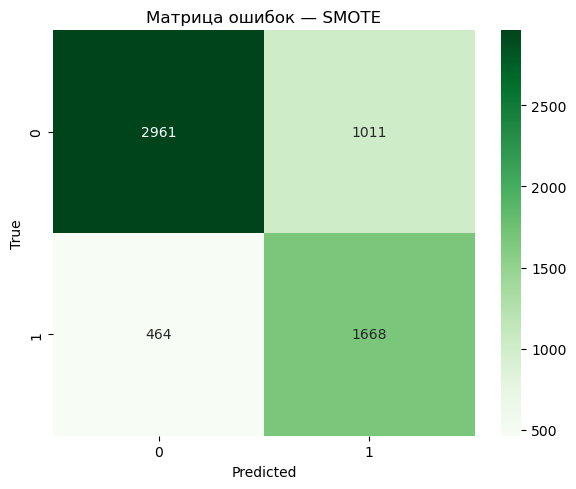

In [ ]:
plot_confusion_matrix_simple(y_train, y_pred_smote_dt, title="Матрица ошибок — SMOTE")

## Общий пайплайн

In [ ]:
pipeline_combined = ImbPipeline([
    ("preprocess", processor),
    ("sampler", "passthrough"), 
    ("dectree", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid_combined = {
    'sampler': [
        'passthrough',                                   
        RandomUnderSampler(random_state=RANDOM_STATE),   
        RandomOverSampler(random_state=RANDOM_STATE),    
        SMOTE(random_state=RANDOM_STATE, k_neighbors=5)  
    ],
    'dectree__max_depth': [3, 5, 6, 7, 9, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [1, 5, 10, 15, 20],
    'dectree__max_features': [None, 'sqrt', 'log2'],
    'dectree__criterion': ['gini', 'entropy'],
    'dectree__class_weight': [None, 'balanced']
}

gs_combined = GridSearchCV(
    pipeline_combined,
    param_grid=param_grid_combined,
    cv=skf,
    scoring="recall",
    n_jobs=-1,
    verbose=1
)

gs_combined.fit(X_train, y_train)

print("\n" + "="*50)
print("Лучший результат общего пайплайна:")
print(f"Best params: {gs_combined.best_params_}")
print(f"Best Recall: {gs_combined.best_score_:.4f}")
print("="*50)

Fitting 5 folds for each of 5760 candidates, totalling 28800 fits

Лучший результат общего пайплайна:
Best params: {'dectree__class_weight': 'balanced', 'dectree__criterion': 'entropy', 'dectree__max_depth': 3, 'dectree__max_features': 'sqrt', 'dectree__min_samples_leaf': 1, 'dectree__min_samples_split': 2, 'sampler': 'passthrough'}
Best Recall: 0.8462



Отчёт классификации (Best Estimator):
              precision    recall  f1-score   support

           0       0.89      0.67      0.76      3972
           1       0.58      0.85      0.69      2132

    accuracy                           0.73      6104
   macro avg       0.73      0.76      0.73      6104
weighted avg       0.78      0.73      0.74      6104



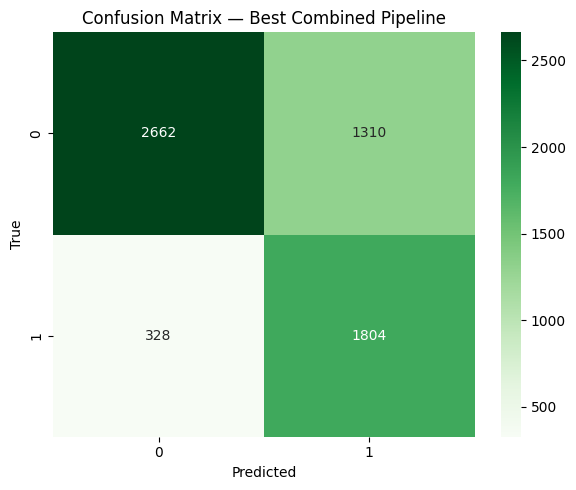

In [17]:
y_pred_combined = cross_val_predict(
    gs_combined.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("\nОтчёт классификации (Best Estimator):")
print(classification_report(y_train, y_pred_combined))

plot_confusion_matrix_simple(y_train, y_pred_combined, title="Confusion Matrix — Best Combined Pipeline")

## Лучший пайплайн

Среди всех рассмотренных моделей на данный момент оптимальной по балансу метрик recall и precision является модель *Decision Tree с весами классов*:

- recall - 0.85
- precision - 0.58

Можем получить информацию о логике работы решающего дерева в графическом и текстовом виде. На практике данный подход позволил бы легко и точно интерпретировать решения модели.

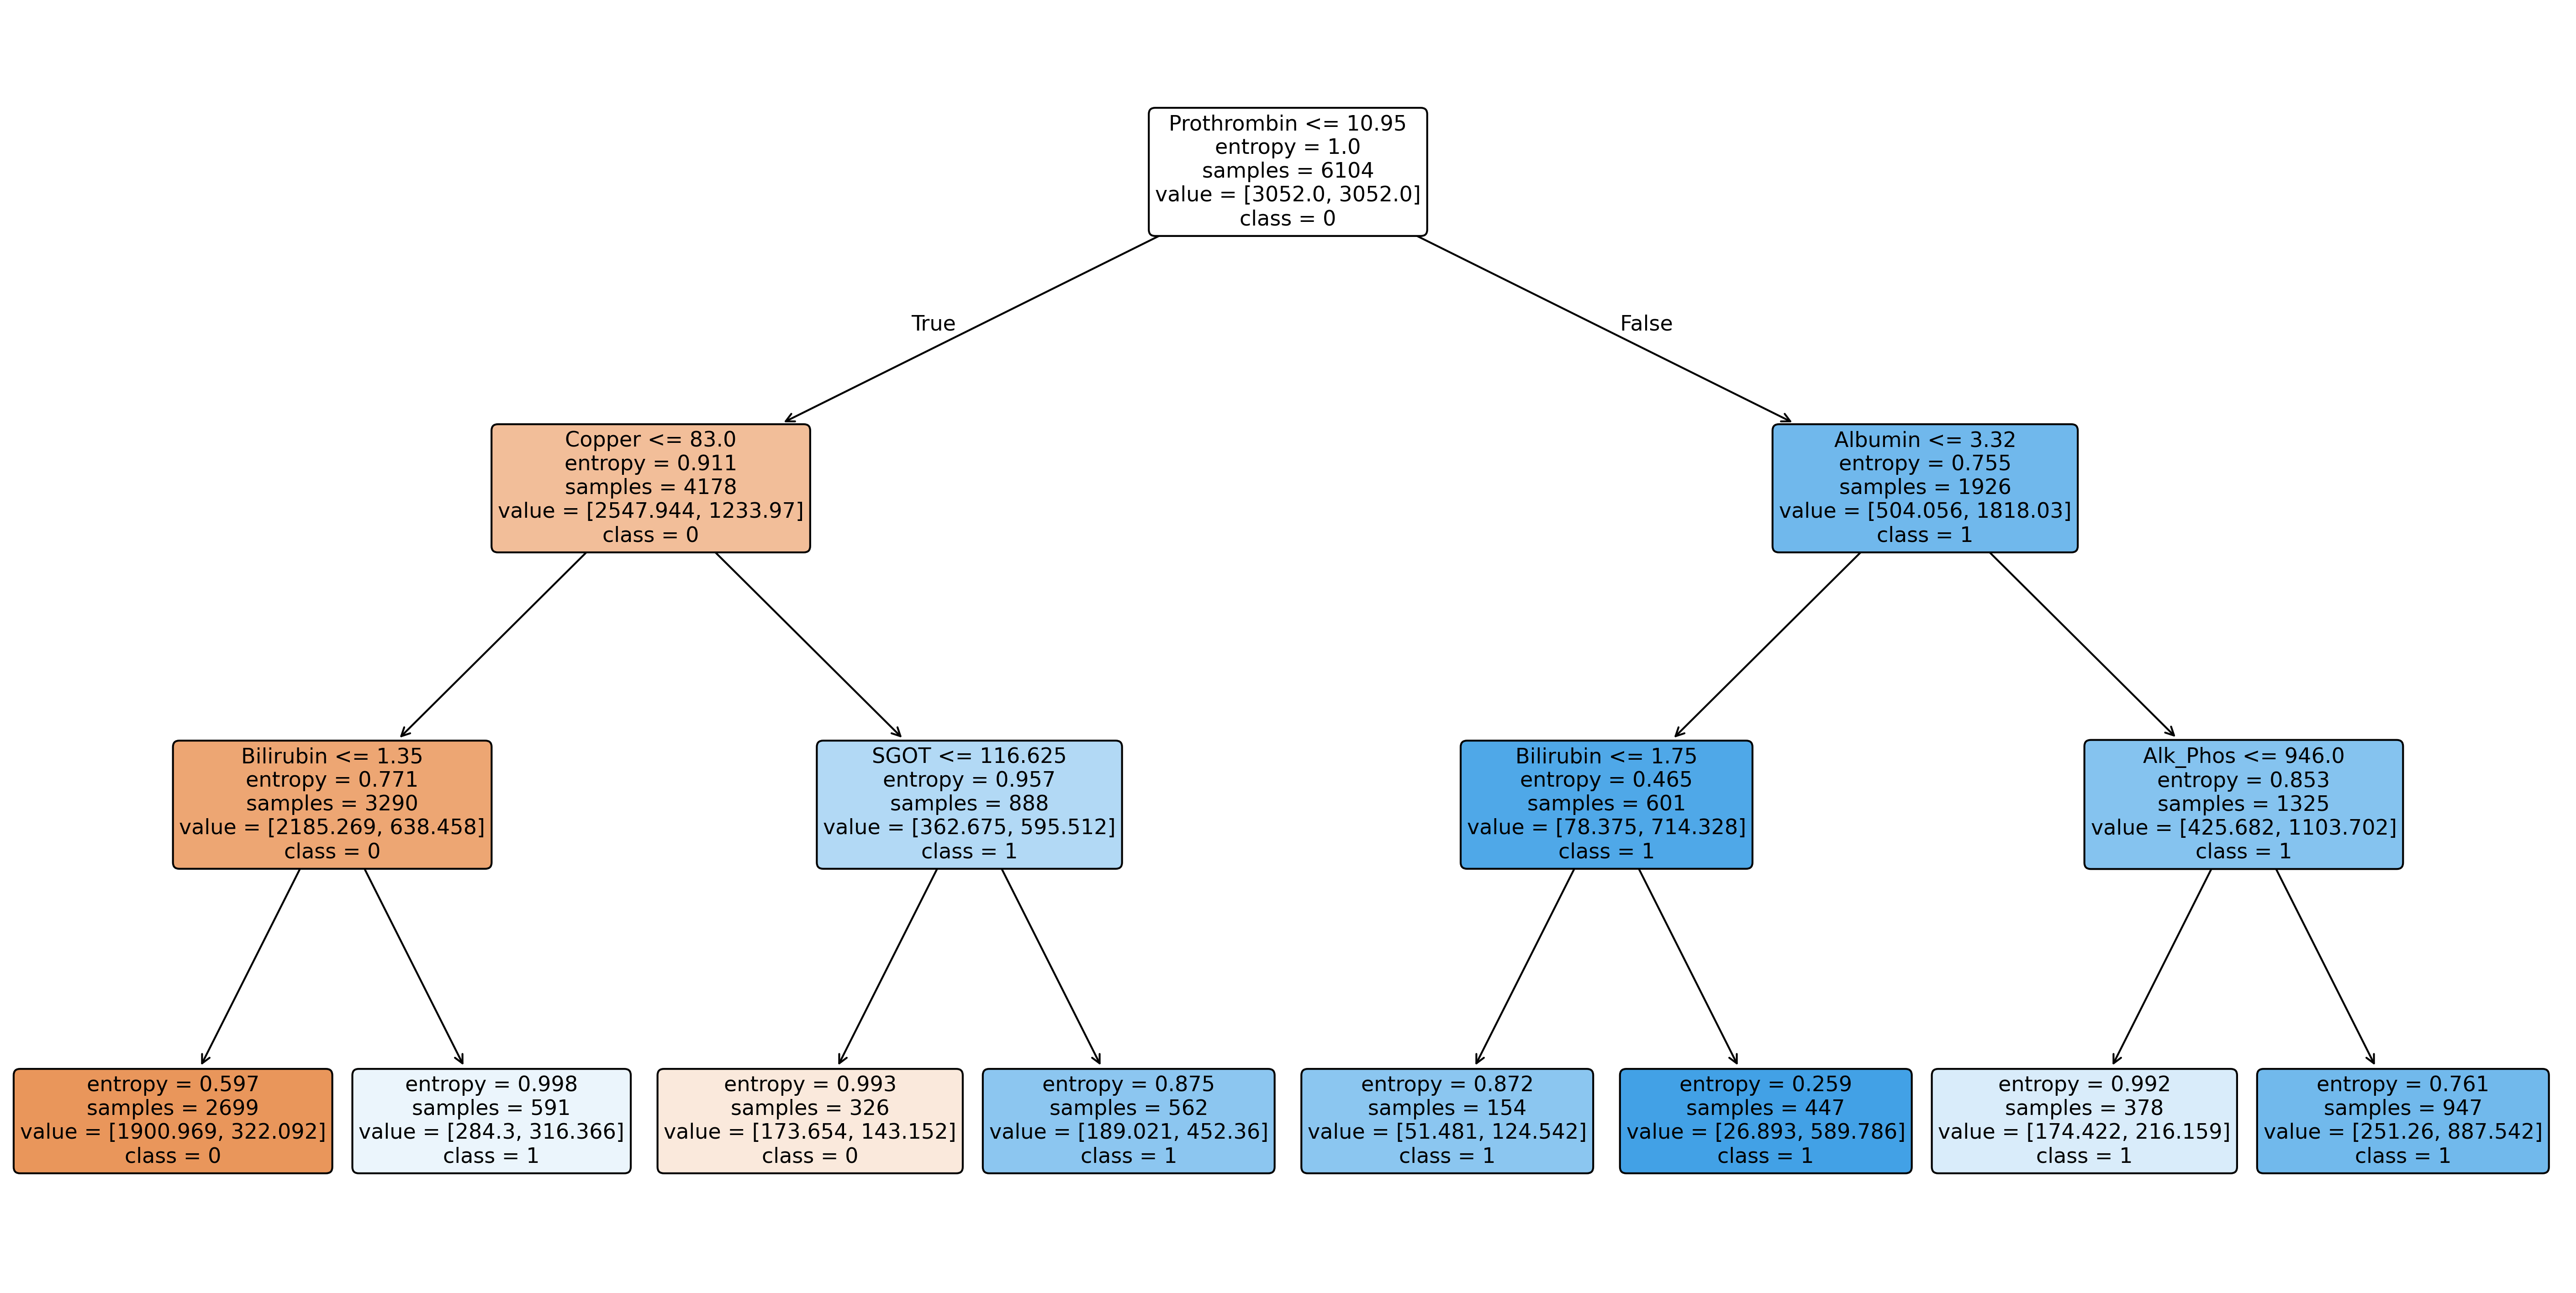

In [24]:
plot_tree_from_estimator(gs_dt)

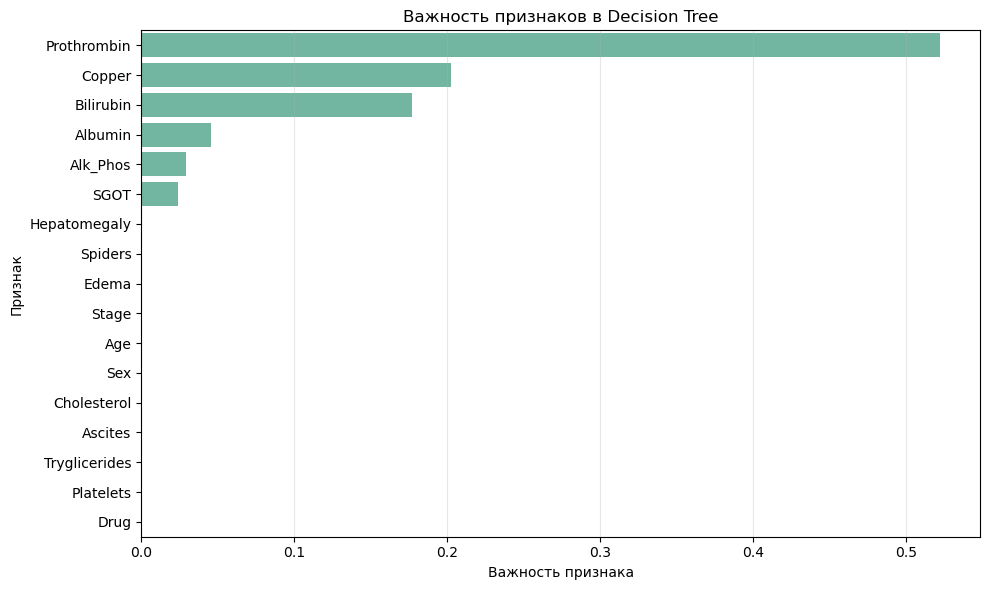

,feature,importance
16,Prothrombin,0.522132
11,Copper,0.202426
8,Bilirubin,0.177074
10,Albumin,0.045494
12,Alk_Phos,0.029097
13,SGOT,0.023777
3,Hepatomegaly,0.000000
4,Spiders,0.000000
5,Edema,0.000000
6,Stage,0.000000


In [25]:
plot_feature_importances(gs_dt, model_step_name="dectree",
                         title="Важность признаков в Decision Tree")

Попробуем подобрать порог, чтобы максимизировать recall, но не сильно потерять в precision

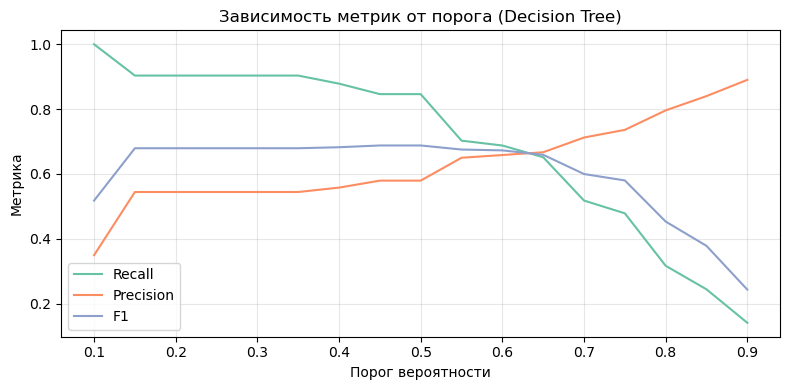

In [26]:
plot_threshold_curves(gs_dt, X_train, y_train, cv=skf,
                      title="Зависимость метрик от порога (Decision Tree)")

In [27]:
THRESHOLD = 0.35

y_proba_dt = cross_val_predict(
    gs_dt.best_estimator_,
    X_train, y_train,
    method="predict_proba",
    cv=skf,
    n_jobs=-1
)[:, 1]

y_pred_dt_thr = (y_proba_dt >= THRESHOLD).astype(int)

print(f"Отчёт по классам (модель с весами классов и порогом {THRESHOLD}):")
print(classification_report(y_train, y_pred_dt_thr))

Отчёт по классам (модель с весами классов и порогом 0.35):
              precision    recall  f1-score   support

           0       0.92      0.59      0.72      3972
           1       0.54      0.90      0.68      2132

    accuracy                           0.70      6104
   macro avg       0.73      0.75      0.70      6104
weighted avg       0.79      0.70      0.71      6104



## Feature Engineering

Попробуем сгенерировать дополнительные признаки, которые могут улучшить качество модели

In [28]:
class SymptomScoreTransformer(BaseEstimator, TransformerMixin):
    """
    Symptom_Score - суммарное кол-во осложнений (Ascites, Hepatomegaly, Spiders, Edema)
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        mapping = {'N': 0, 'Y': 1, 'S': 1}

        ascites = X['Ascites'].map(mapping)
        hepatomegaly = X['Hepatomegaly'].map(mapping)
        spiders = X['Spiders'].map(mapping)
        edema = X['Edema'].map(mapping)

        X['Symptom_Score'] = ascites + hepatomegaly + spiders + edema
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        input_features = list(input_features)
        return np.array(input_features + ["Symptom_Score"], dtype=object)


class BilirubinAlbuminRatioTransformer(BaseEstimator, TransformerMixin):
    """
    Bilirubin_Albumin_Ratio = Bilirubin / Albumin
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Bilirubin_Albumin_Ratio'] = X['Bilirubin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Bilirubin_Albumin_Ratio"], dtype=object)
    

class CoagulationIndexTransformer(BaseEstimator, TransformerMixin):
    """
    Coagulation_Index = Prothrombin / Albumin (показатель синтетической функции печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Coagulation_Index'] = X['Prothrombin'] / (X['Albumin'] + eps)
        return X

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Coagulation_Index"], dtype=object)
    

class EnzymePatternTransformer(BaseEstimator, TransformerMixin):
    """
    Добавляет Enzyme_Pattern = SGOT / Alk_Phos (тип поражения печени)*
    """
    def fit(self, X, y=None):
        self.feature_names_in_ = X.columns.to_list()
        return self

    def transform(self, X):
        X = X.copy()
        eps = 1e-6
        X['Enzyme_Pattern'] = X['SGOT'] / (X['Alk_Phos'] + eps)
        return X
    
    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            input_features = self.feature_names_in_
        return np.array(list(input_features) + ["Enzyme_Pattern"], dtype=object)

* CoagulationIndex — это отношение протромбина к альбумину. Оно отражает синтетическую функцию печени: при тяжёлом циррозе протромбиновое время растёт, а альбумин падает. Поэтому высокий индекс означает выраженную печёночную недостаточность и высокий риск неблагоприятного исхода. Эти параметры входят в шкалу Child-Pugh.

* Enzyme_Pattern — соотношение SGOT и щелочной фосфатазы отражает так называемый ферментный паттерн. Высокое значение указывает на гепатоцеллюлярное повреждение (клеточное воспаление), а низкое — на холестаз. В циррозе преобладание холестаза часто связано с более тяжёлым течением, поэтому этот индекс помогает дереву улавливать тип поражения печени.

In [29]:
fe_preprocessor = Pipeline([
    ("symptom_score", SymptomScoreTransformer()),
    ("bilirubin_albumin_ratio", BilirubinAlbuminRatioTransformer()),
    ("coagulation_index", CoagulationIndexTransformer()),
    ("enzyme_pattern", EnzymePatternTransformer()),
    ("encode", ColumnTransformer(
        transformers=[
            ("binary", BinaryMapper(binary_maps), binary_features),
            ("category", OrdinalEncoder(), multi_category_features)
        ],
        remainder="passthrough",
        verbose_feature_names_out=False
    ))
])

decision_tree_fe = Pipeline([
    ("preprocess", fe_preprocessor),
    ("dectree", DecisionTreeClassifier(
        random_state=RANDOM_STATE))
])

param_grid = {
    'dectree__max_depth': [3, 5, 7, 10, None],
    'dectree__min_samples_split': [2, 5, 10, 15],
    'dectree__min_samples_leaf': [1, 5, 10, 15, 20],
    'dectree__max_features': [None, 'sqrt', 'log2'],
    'dectree__criterion': ['gini', 'entropy'],
    'dectree__class_weight': [None, 'balanced']
}

gs_dt_fe = GridSearchCV(
    decision_tree_fe,
    param_grid=param_grid,
    cv=skf,
    scoring="recall",
    n_jobs=-1
)

gs_dt_fe.fit(X_train, y_train)
print("Дерево решений:")
print("Лучшие параметры:", gs_dt_fe.best_params_)
print("Лучший recall на кросс-валидации:", gs_dt_fe.best_score_)

Дерево решений:
Лучшие параметры: {'dectree__class_weight': 'balanced', 'dectree__criterion': 'entropy', 'dectree__max_depth': 3, 'dectree__max_features': None, 'dectree__min_samples_leaf': 1, 'dectree__min_samples_split': 2}
Лучший recall на кросс-валидации: 0.7987762641422305


C:\Users\dmitry.volobuev_inde\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [30]:
y_pred_dt_fe = cross_val_predict(
    gs_dt_fe.best_estimator_,
    X_train, y_train,
    cv=skf,
    n_jobs=-1
)

print("Отчёт по классам (модель decision tree с доп. признаками):")
print(classification_report(y_train, y_pred_dt_fe))

Отчёт по классам (модель decision tree с доп. признаками):
              precision    recall  f1-score   support

           0       0.88      0.77      0.82      3972
           1       0.65      0.80      0.72      2132

    accuracy                           0.78      6104
   macro avg       0.77      0.79      0.77      6104
weighted avg       0.80      0.78      0.79      6104



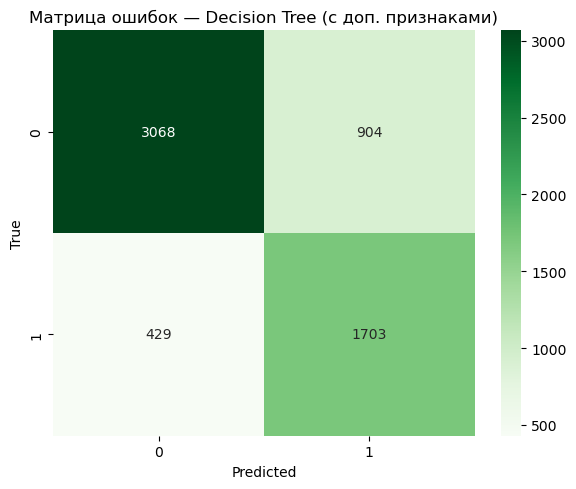

In [31]:
plot_confusion_matrix_simple(y_train, y_pred_dt_fe,
                             title="Матрица ошибок — Decision Tree (с доп. признаками)")

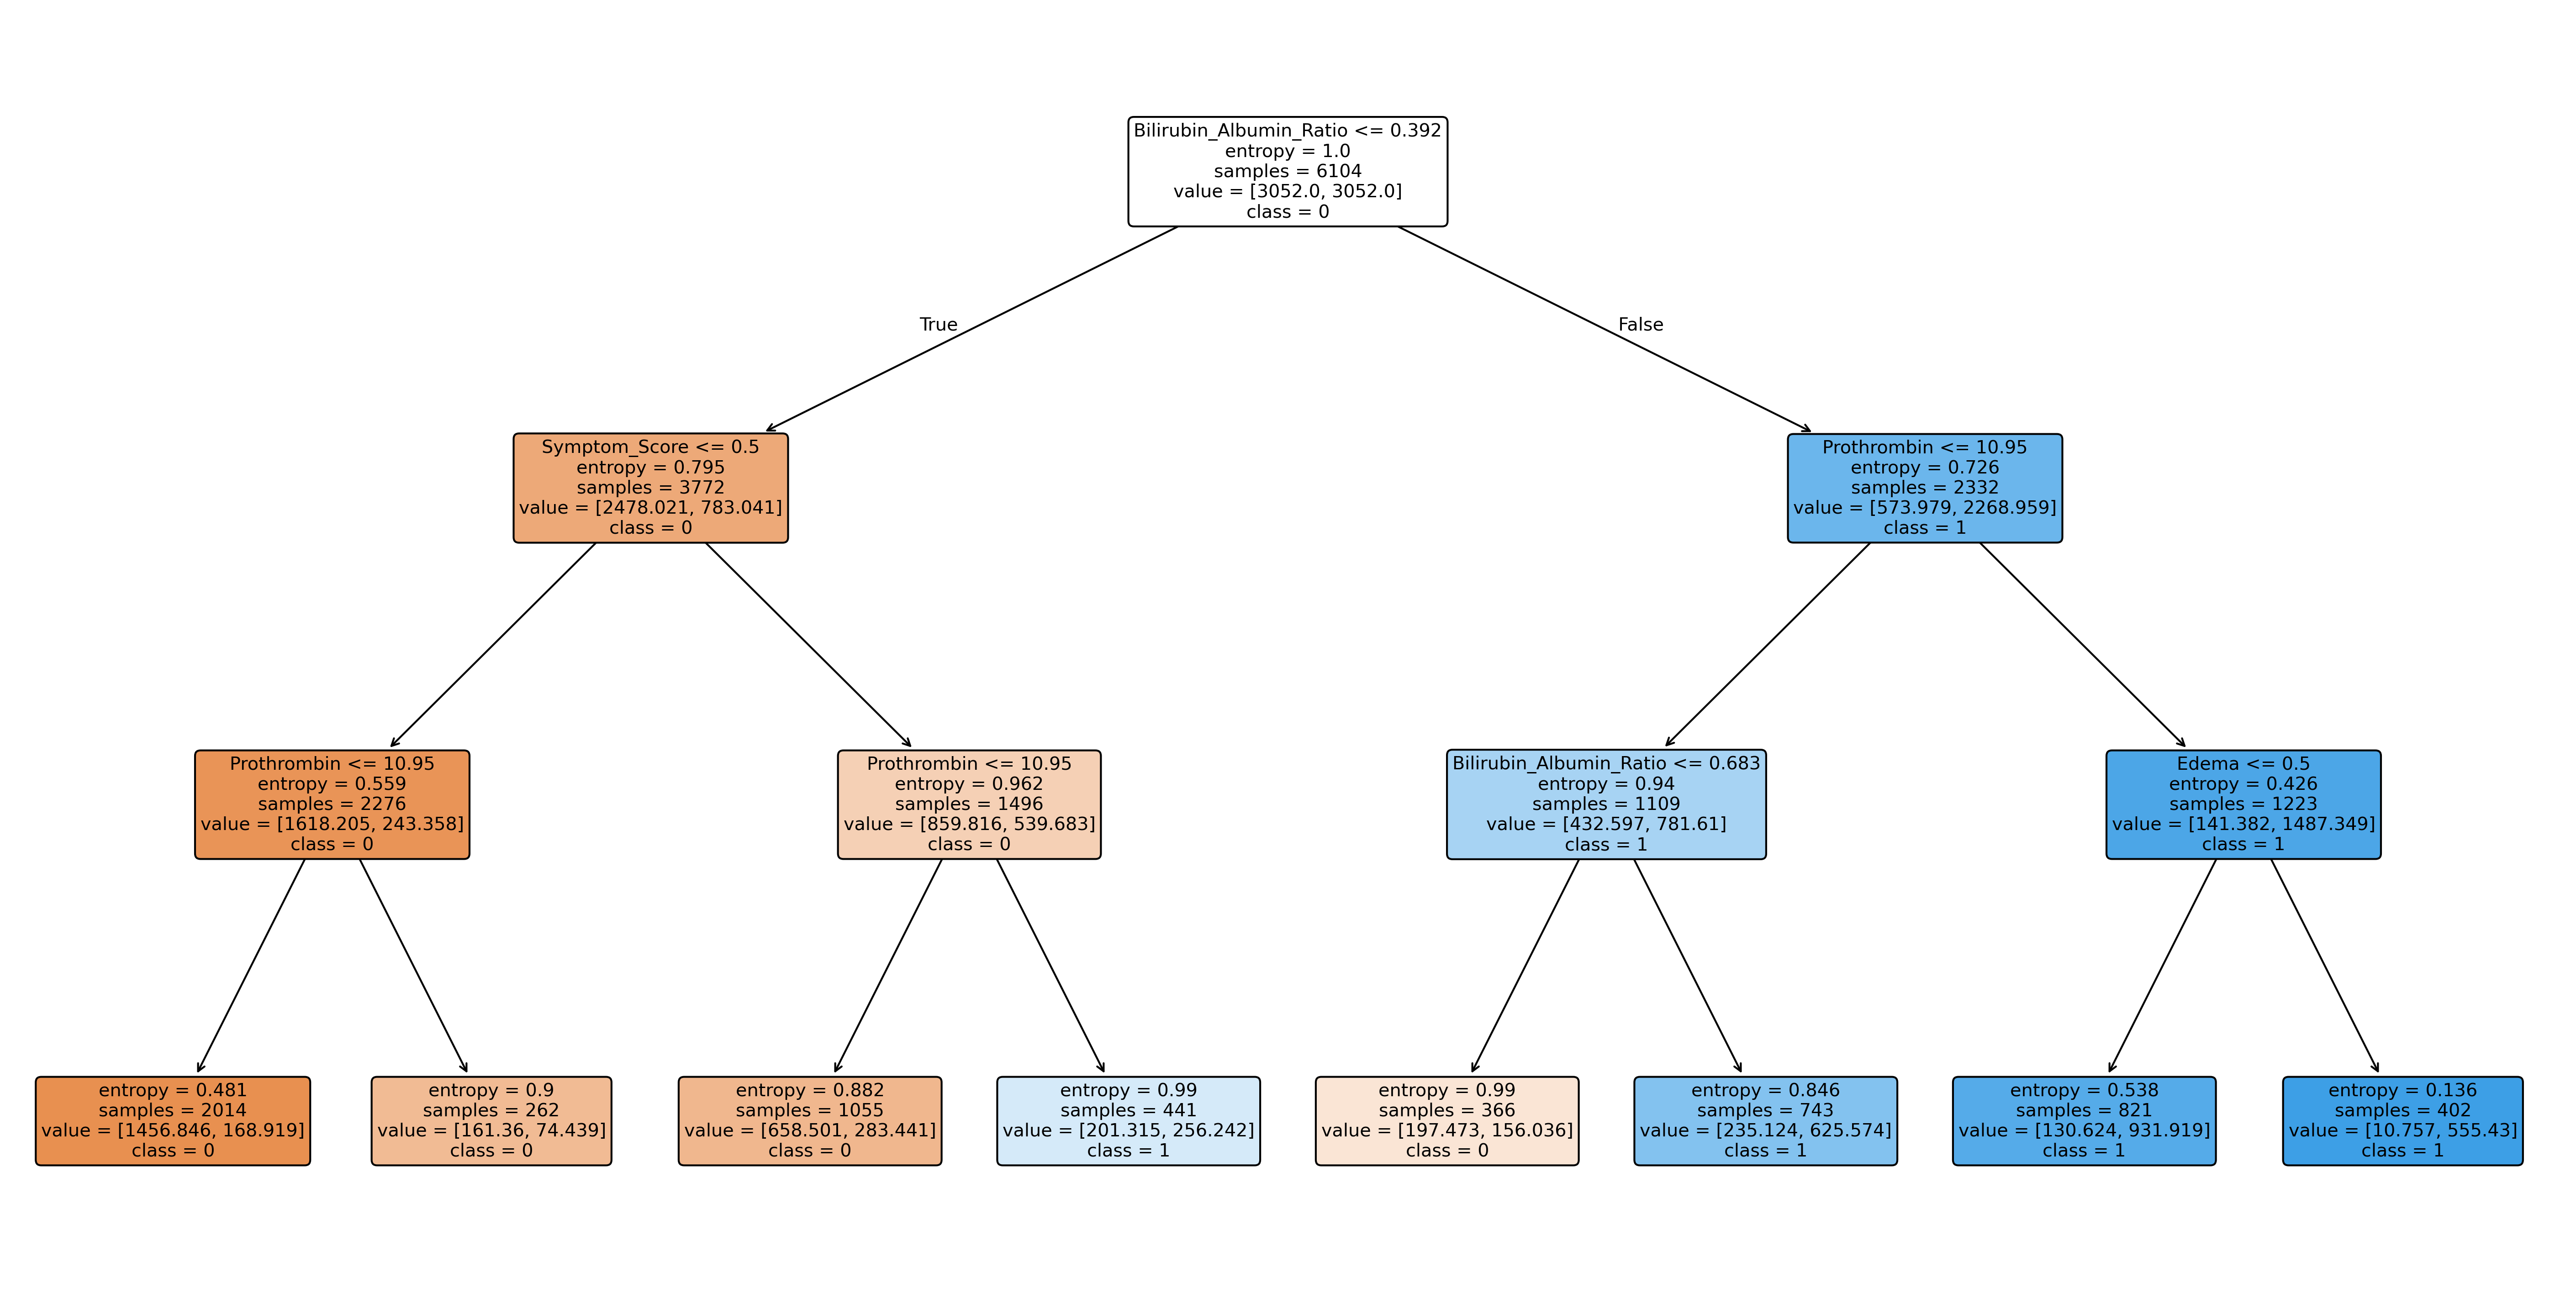

In [32]:
plot_tree_from_estimator(gs_dt_fe)

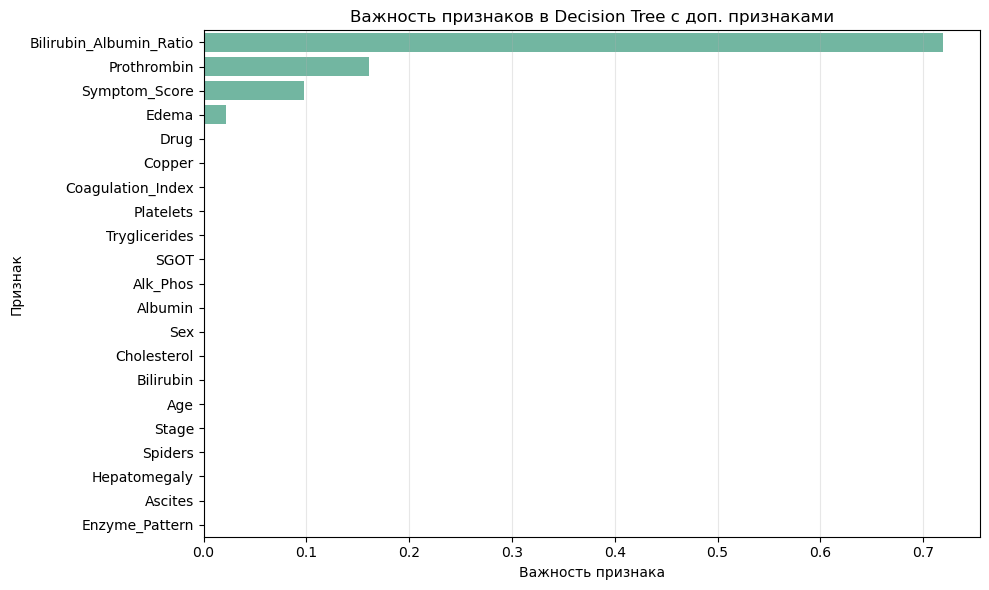

,feature,importance
18,Bilirubin_Albumin_Ratio,0.719451
16,Prothrombin,0.161063
17,Symptom_Score,0.097992
5,Edema,0.021495
0,Drug,0.000000
11,Copper,0.000000
19,Coagulation_Index,0.000000
15,Platelets,0.000000
14,Tryglicerides,0.000000
13,SGOT,0.000000


In [33]:
plot_feature_importances(gs_dt_fe, model_step_name="dectree",
                         title="Важность признаков в Decision Tree с доп. признаками")

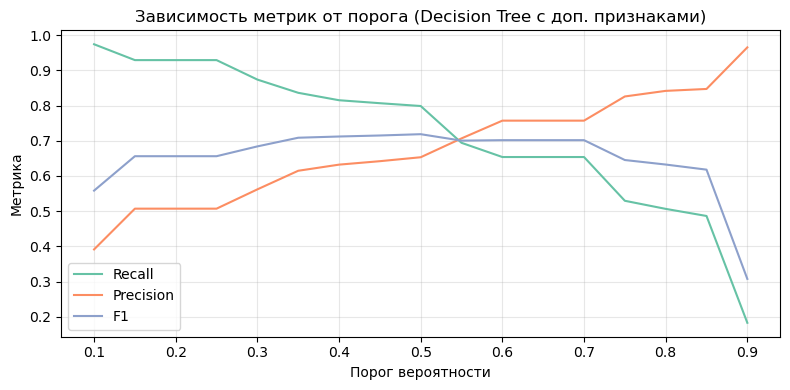

In [34]:
plot_threshold_curves(gs_dt_fe, X_train, y_train, cv=skf,
                      title="Зависимость метрик от порога (Decision Tree с доп. признаками)")

# Этап III. Проверка на тесте

In [35]:
best_params = gs_dt.best_params_
print(f"Лучшие параметры: {best_params}")

Лучшие параметры: {'dectree__class_weight': 'balanced', 'dectree__criterion': 'entropy', 'dectree__max_depth': 3, 'dectree__max_features': 'sqrt', 'dectree__min_samples_leaf': 1, 'dectree__min_samples_split': 2}


In [36]:
final_pipeline = Pipeline([
    ("preprocess", processor),
    ("dectree", DecisionTreeClassifier(
        random_state=RANDOM_STATE,
        max_depth=best_params['dectree__max_depth'],
        min_samples_split=best_params['dectree__min_samples_split'],
        min_samples_leaf=best_params['dectree__min_samples_leaf'],
        max_features=best_params['dectree__max_features'],
        criterion=best_params['dectree__criterion'],
        class_weight=best_params['dectree__class_weight']
    ))
])

# обучение на всём train
final_pipeline.fit(X_train, y_train)

C:\Users\dmitry.volobuev_inde\anaconda3\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary',
                                                  BinaryMapper(mapping={'Ascites': {'N': 0,
                                                                                    'Y': 1},
                                                                        'Drug': {'D-penicillamine': 1,
                                                                                 'Placebo': 0},
                                                                        'Hepatomegaly': {'N': 0,
                                                                                         'Y': 1},
                                                                        'Sex': {'F': 0,
                                                                                'M': 1},
                                                                        'Spiders': {'N': 0,
                                                                                    'Y': 1}}),
                                                  ['Drug', 'Sex', 'Ascites',
                                                   'Hepatomegaly', 'Spiders']),
                                                 ('category', OrdinalEncoder(),
                                                  ['Edema', 'Stage'])],
                                   verbose_feature_names_out=False)),
                ('dectree',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=3,
                                        max_features='sqrt',
                                        random_state=42))])

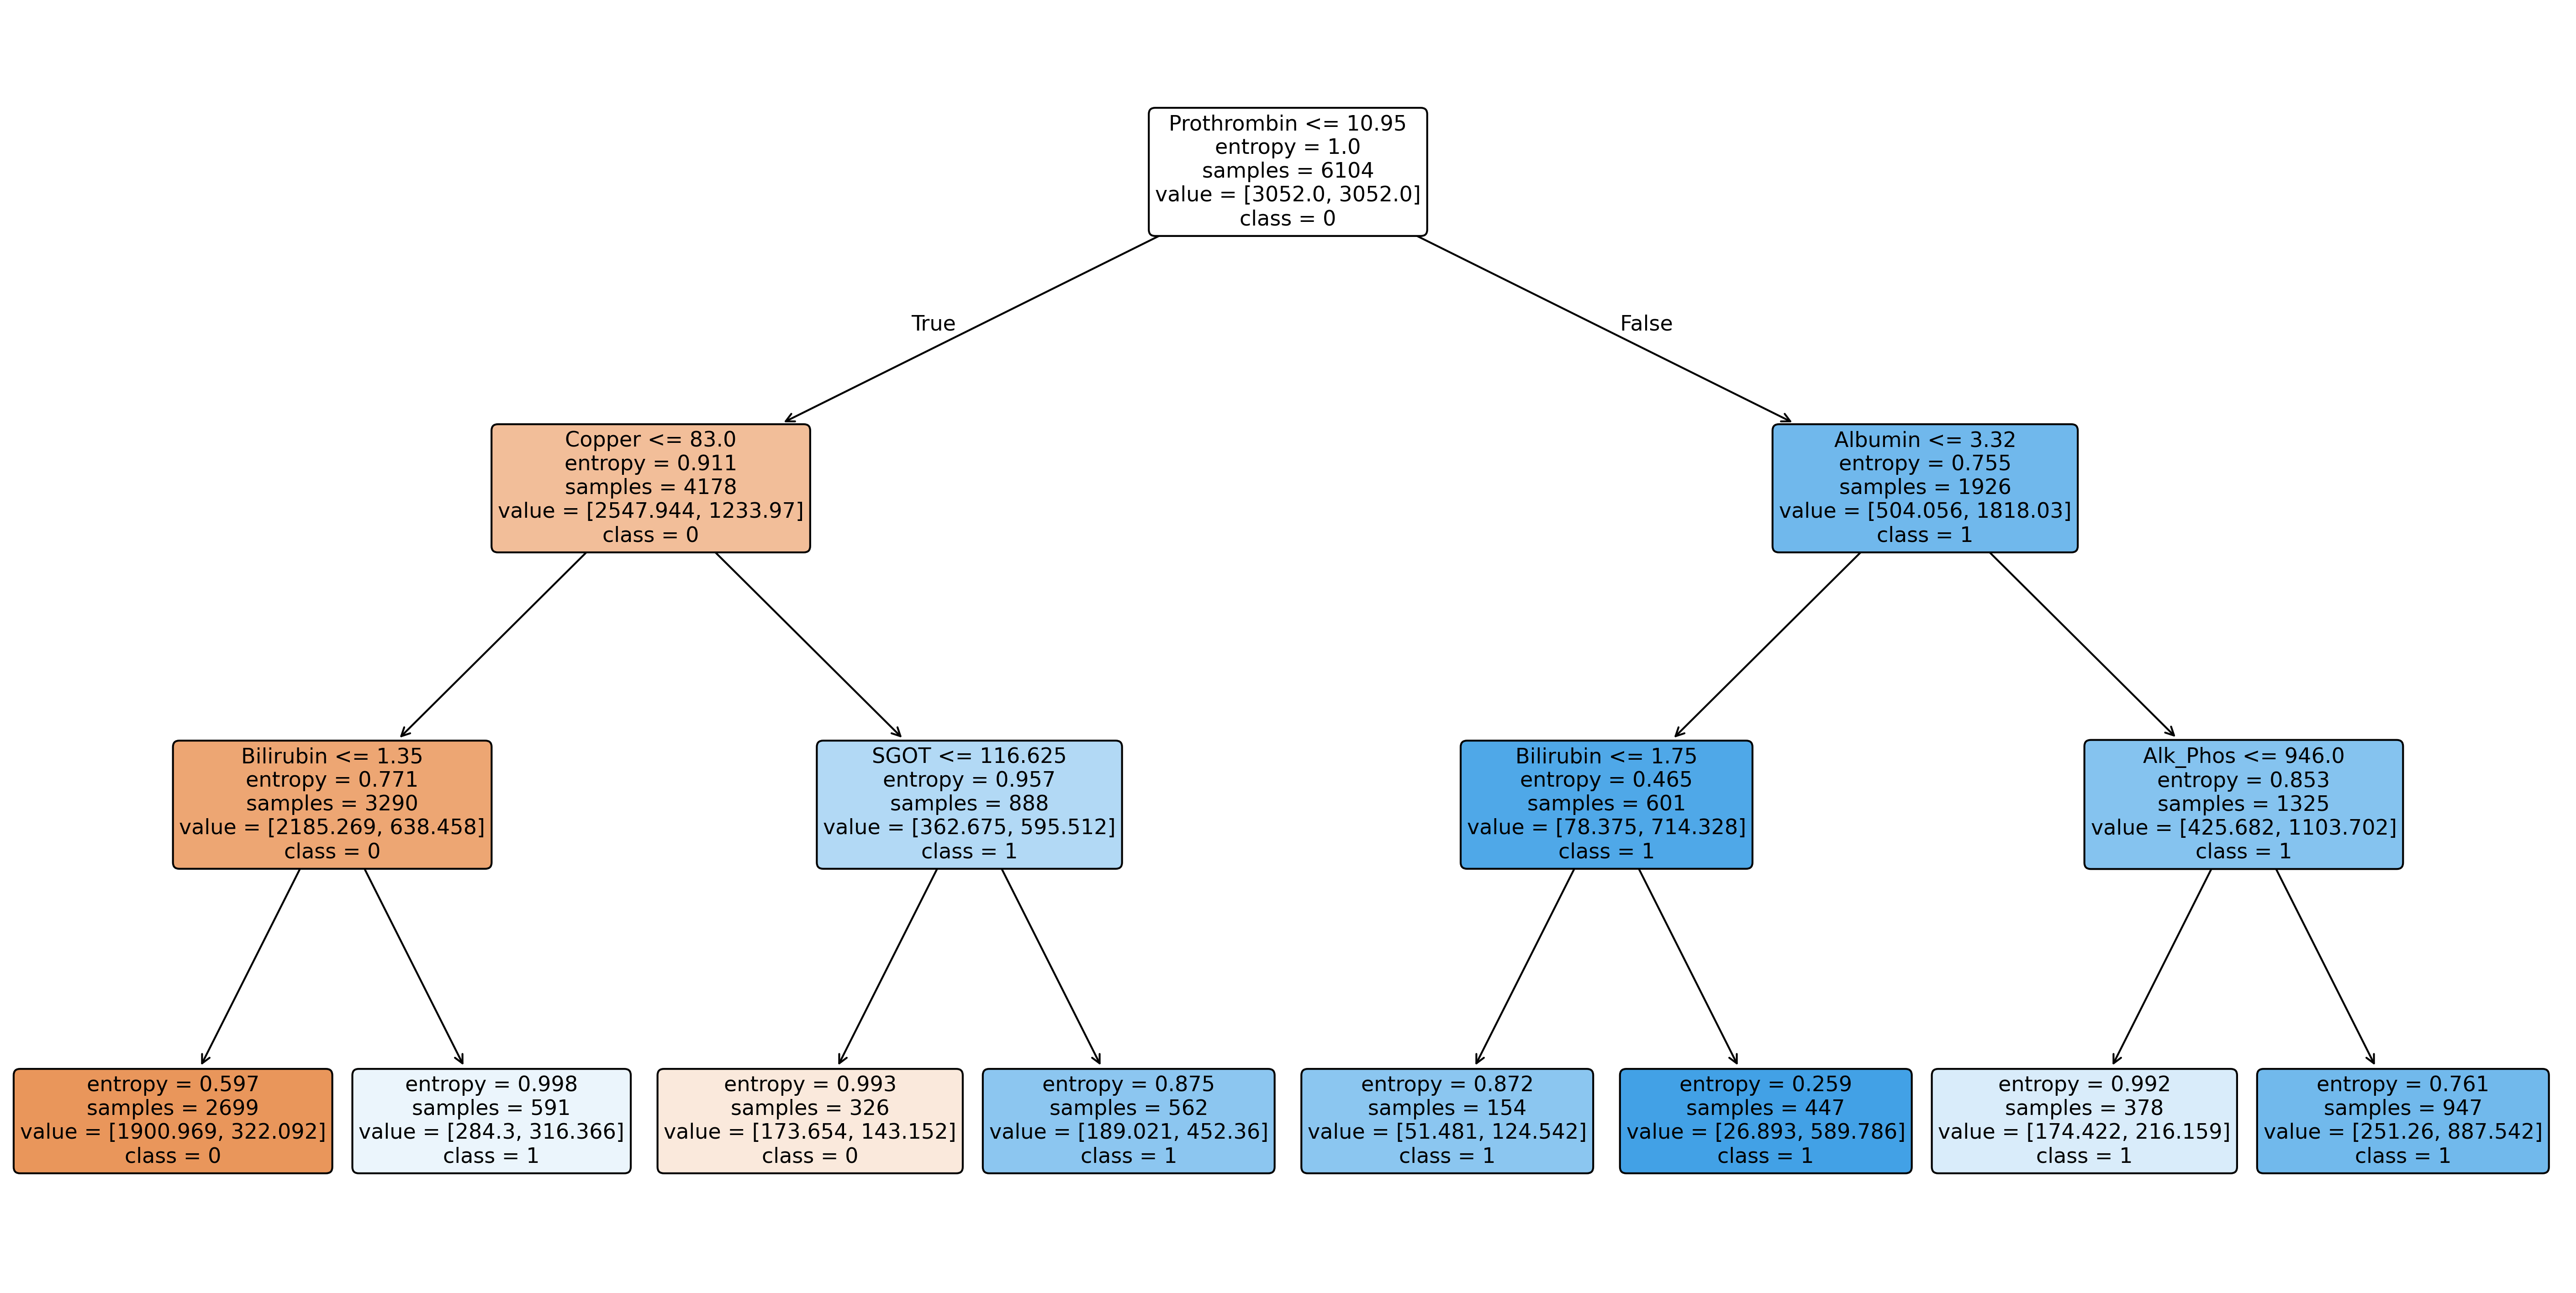

In [37]:
plot_tree_from_estimator(final_pipeline)

In [38]:
THRESHOLD = 0.35

y_proba_test = final_pipeline.predict_proba(X_test)[:, 1]
y_pred_test = (y_proba_test >= THRESHOLD).astype(int)

In [39]:
print(f"Отчёт по классам на тесте (threshold={THRESHOLD}):")
print(classification_report(y_test, y_pred_test))

Отчёт по классам на тесте (threshold=0.35):
              precision    recall  f1-score   support

           0       0.91      0.60      0.72       993
           1       0.54      0.88      0.67       533

    accuracy                           0.70      1526
   macro avg       0.72      0.74      0.69      1526
weighted avg       0.78      0.70      0.70      1526



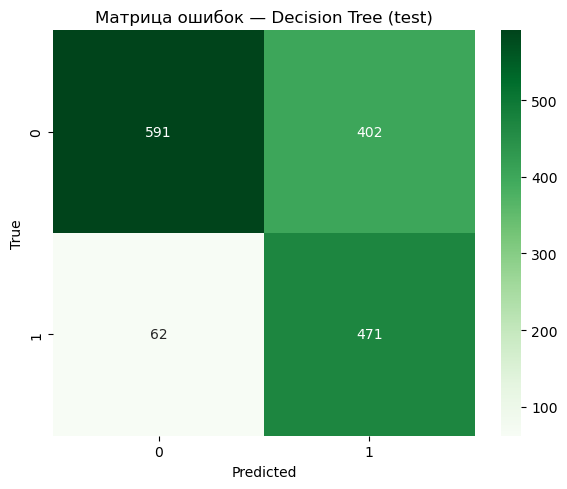

In [40]:
plot_confusion_matrix_simple(y_test, y_pred_test,
                             title="Матрица ошибок — Decision Tree (test)")

# Выводы

**Моделирование:**

Проведена оценка моделей Decision Tree, использующих разные методы для борьбы с дисбалансом классов. Лучший результат по метрике recall для класса 1 показало дерево решений с весами классов. Кроме того, были проведены эксперименты по изменению порога принятия решений и генерации дополнительных признаков.  

**Результаты:**

На тесте выбранная модель (с весами классов, порогом в 0.35 и без доп. признаков) показывает recall класса 1 = 0.88 и precision класса 1 = 0.54, что уступает логистической регрессии (0.90 и 0.59 соответственно), однако при этом дерево решений обладает большей интерпретируемостью. Важнейшие признаки по версии дерева решений: Prothrombin, Copper, Bilirubin, Albumin.